In [1]:
%matplotlib inline
import sys, os, time
from itertools import product

import rasterio as rio
import rasterio.mask as masker
import rasterio.plot as rplt
import rasterio.features
import rasterio.warp
import rasterio.windows as wnd

import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [9]:
def plot_shape(shape):
    figsize = (10,6)
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    sns.mpl.rc("figure", figsize=figsize)
    plt.figure(figsize = figsize)
    x = [i[0] for i in biggest.points]
    y = [i[1] for i in biggest.points]
    plt.plot(x, y, 'k')
    plt.show()
    
def get_tiles(dataset, width=512, height=512):
    ncols, nrows = dataset.meta['width'], dataset.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
    for col_off, row_off in offsets:
        window = wnd.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, dataset.transform)
        yield window, transform

def get_tile(file, width=512, height=512, col_off=0, row_off=0):
    with rio.open(file, dtype='float32') as data:
        
        meta = data.meta.copy()
        
        ncols, nrows = meta['width'], meta['height']
        offsets = product(range(0, ncols, width), range(0, nrows, height))
        big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
        window = wnd.Window(col_off=col_off * width, row_off=row_off * height, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, data.transform)
        
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        return data.read(window=window).transpose(1,2,0)
    

In [10]:
landsatTileList = r"/home/dsa/DSA/images/scene_list.txt"
landsatDirectory = r"/home/dsa/DSA/images/LC08_L1GT_209117_20140101_20170427_01_T2"
coastMaskShpfile = r"/home/dsa/DSA/vectors/Coastline_high_res_polygon_v7.1.shp"

outputDirectory = r"/home/dsa/DSA/vectors/"
outputFileExt = r"_burjo_output.tif"

assert os.path.isfile(landsatTileList)
assert os.path.isdir(landsatDirectory)
assert os.path.isfile(coastMaskShpfile)

In [11]:
tiles = open(landsatTileList).read().splitlines()
print(tiles)

['LC08_L1GT_209117_20140101_20170427_01_T2']


In [12]:
startTime = time.ctime()

In [13]:
print("ArcPy Rock masking script started: %s" % startTime)

ArcPy Rock masking script started: Mon Oct 14 09:54:55 2019


In [ ]:
with shp.Reader(coastMaskShpfile) as coast:
    print(coast)

    biggest = max(coast.shapes(), key=lambda x: len(x.points))

plot_shape(biggest)

In [14]:
for i in range(len(tiles)):
    
    thisTileID = tiles[i]
    thisTileFile = landsatDirectory + "/" + thisTileID
    outFilename = outputDirectory + "/" + thisTileID
    
    fmt = "\t%d of %d."
    print(fmt % (i + 1, len(tiles)))
    tic = time.time()

	1 of 1.


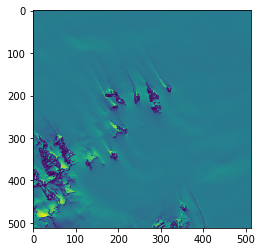

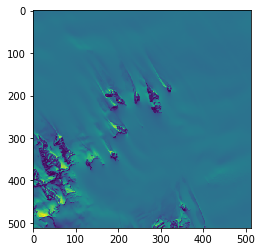

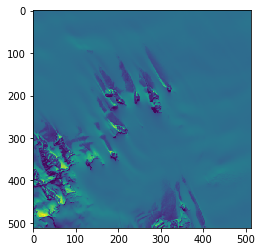

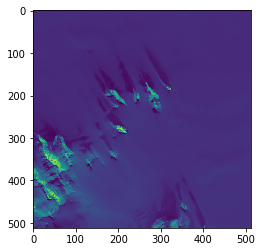

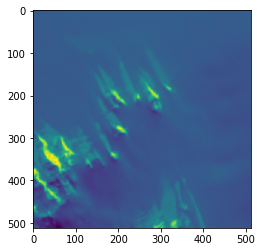

In [15]:
col_off = 11 
row_off = 12
B2 = get_tile(thisTileFile + "_B2.TIF", col_off=col_off, row_off=row_off)


B3 = get_tile(thisTileFile + "_B3.TIF", col_off=col_off, row_off=row_off)

B5 = get_tile(thisTileFile + "_B5.TIF", col_off=col_off, row_off=row_off)

B6 = get_tile(thisTileFile + "_B6.TIF", col_off=col_off, row_off=row_off)

B10 = get_tile(thisTileFile + "_B10.TIF", col_off=col_off, row_off=row_off)

rplt.show(B2)
rplt.show(B3)
rplt.show(B5)
rplt.show(B6)
rplt.show(B10)

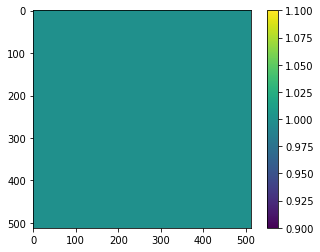

In [16]:
# The example tile is landlocked. skipping coastline mask for now
coastMaskBin = (B2 > 0).astype(int)

plt.imshow(coastMaskBin.squeeze())
plt.colorbar()

In [17]:
toc = time.time()
print(" Loaded & Coast Masked (%.02fs)." % (toc - tic))
tic = time.time()

 Loaded & Coast Masked (14.53s).


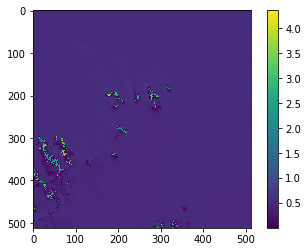

In [18]:
ndsi = (B3 - B6) / (B3 + B6)
plt.imshow(ndsi.squeeze())
plt.colorbar()

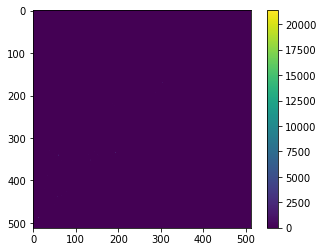

In [19]:
ndwi = (B3 - B5) / (B3 + B5)
plt.imshow(ndwi.squeeze())
plt.colorbar()

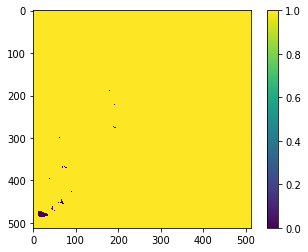

In [30]:
mask1_step1 = ((B10 / B2) > 0.4).astype(int)

plt.imshow(mask1_step1.squeeze())
plt.colorbar()

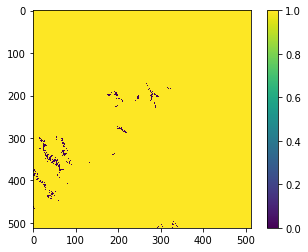

In [31]:
mask1_step2 = (ndsi < 0.75).astype(int)
plt.imshow(mask1_step2.squeeze())
plt.colorbar()

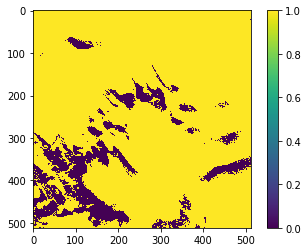

In [32]:
mask1_step3 = (ndwi < 0.45).astype(int)
plt.imshow(mask1_step3.squeeze())
plt.colorbar()

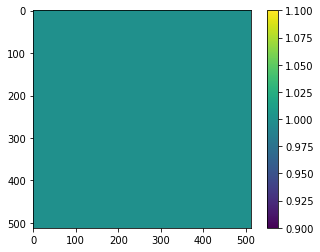

In [33]:
mask1_step5 = (B10 > 2550).astype(int) # Note: this is a scaled value
plt.imshow(mask1_step5.squeeze())
plt.colorbar()

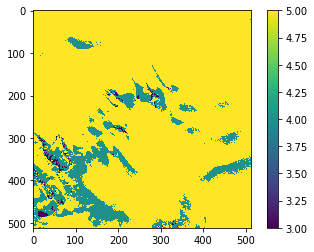

In [34]:
mask1_prefinal = mask1_step1 + mask1_step2 + mask1_step3 + coastMaskBin + mask1_step5

plt.imshow(mask1_prefinal.squeeze())
plt.colorbar()

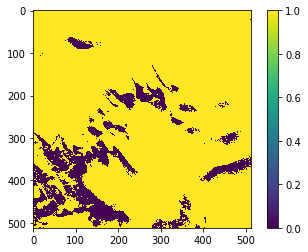

In [35]:
mask1_final = (mask1_prefinal == 5).astype(int)
plt.imshow(mask1_final.squeeze())
plt.colorbar()

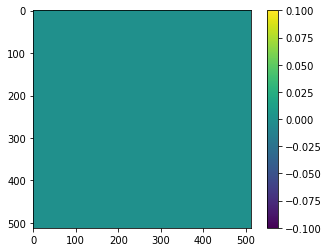

In [36]:
mask2_step1 = (B2 < 2500).astype(int) # note this is a scaled value
plt.imshow(mask2_step1.squeeze())
plt.colorbar()

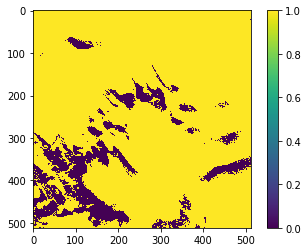

In [37]:
mask2_step2 = (ndwi < 0.45).astype(int)
plt.imshow(mask2_step2.squeeze())
plt.colorbar()

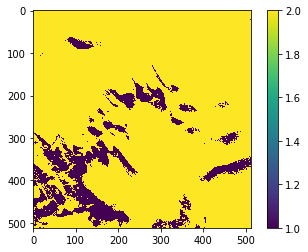

In [38]:
mask2_prefinal = mask2_step1 + mask2_step2 + coastMaskBin
plt.imshow(mask2_prefinal.squeeze())
plt.colorbar()

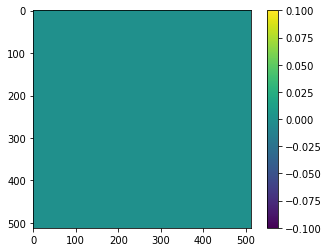

In [39]:
mask2_final = (mask2_prefinal == 3).astype(int)
plt.imshow(mask2_final.squeeze())
plt.colorbar()

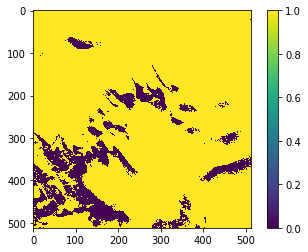

In [41]:
mask_prefinal = mask1_final + mask2_final
plt.imshow(mask_final.squeeze())
plt.colorbar()



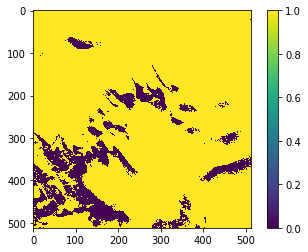

In [42]:
mask_final = (mask_prefinal > 0).astype(int)
plt.imshow(mask_final.squeeze())
plt.colorbar()